## Задание

Создайте автокодировщик, удаляющий черные квадраты в случайных областях изображений.

Алгоритм действий:
1. Возьмите базу картинок Mnist.
2. На картинках в случайных местах сделайте чёрные квадраты размера 8 на 8.
3. Создайте и обучите автокодировщик восстанавливать оригинальные изображения из "зашумленных" квадратом изображений.
4. Добейтесь MSE < 0.0070 на тестовой выборке

## Импорт библиотек

In [25]:
# Отображение
import matplotlib.pyplot as plt

# Для работы с тензорами
import numpy as np

# Класс создания модели
from tensorflow.keras.models import Model

# Для загрузки данных
from tensorflow.keras.datasets import mnist

# Необходимые слои
from tensorflow.keras.layers import Input, Conv2DTranspose, MaxPooling2D, Conv2D, BatchNormalization, Dropout, Cropping2D, Concatenate, LeakyReLU

# Оптимизатор
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.regularizers import l2

## Данные

In [2]:
# Загрузка данных
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Нормировка данных
X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32')/255.
# Изменение формы под удобную для Keras
X_train = X_train.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [4]:
# Функция для добавления черных квадратов
def add_black_squares(images, square_size=8):
    noisy_images = np.copy(images)
    for i in range(len(noisy_images)):
        x = np.random.randint(0, 28 - square_size)
        y = np.random.randint(0, 28 - square_size)
        noisy_images[i, x:x+square_size, y:y+square_size, :] = 0
    return noisy_images

In [5]:
# Создаем зашумленные данные
noisy_X_train = add_black_squares(X_train)
noisy_X_test = add_black_squares(X_test)

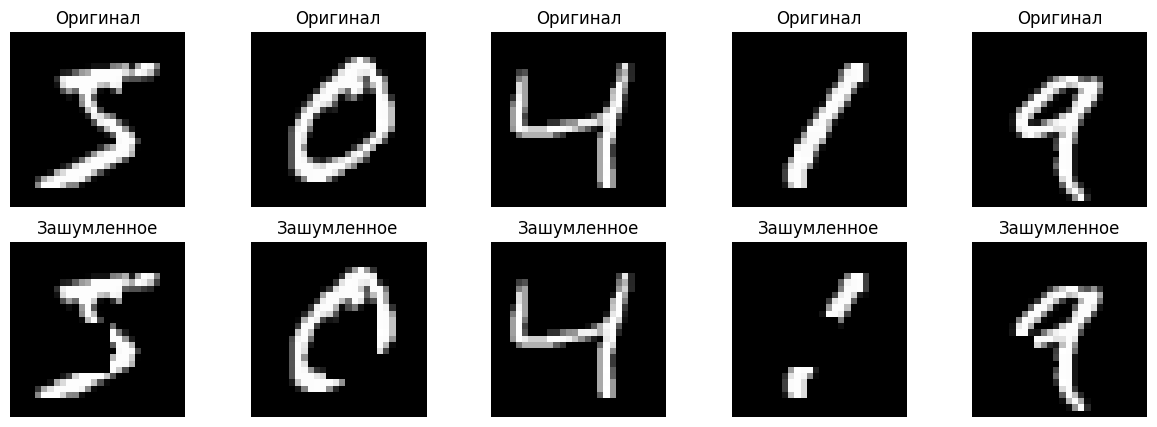

In [6]:
# Визуализация примеров
def plot_examples(original, noisy, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Оригинал
        ax = plt.subplot(2, n, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title("Оригинал")
        plt.axis('off')

        # Зашумленное
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.title("Зашумленное")
        plt.axis('off')
    plt.show()

plot_examples(X_train, noisy_X_train)

#Создаем автокодировщик

In [26]:
# Архитектура автокодировщика
def create_advanced_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Энкодер
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.1)(x1)
    p1 = MaxPooling2D((2, 2), padding='same')(x1)

    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.1)(x2)
    p2 = MaxPooling2D((2, 2), padding='same')(x2)

    # Центральный блок
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU(alpha=0.1)(x3)
    x3 = Dropout(0.3)(x3)

    # Декодер с правильными размерами для конкатенации
    u1 = UpSampling2D((2, 2))(x3)
    u1 = Conv2D(128, (2, 2), activation='relu', padding='same')(u1)  # Изменение размера
    u1 = Concatenate()([u1, x2])  # Теперь размеры совпадают

    x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    x4 = BatchNormalization()(x4)
    x4 = LeakyReLU(alpha=0.1)(x4)

    u2 = UpSampling2D((2, 2))(x4)
    u2 = Conv2D(64, (2, 2), activation='relu', padding='same')(u2)  # Изменение размера
    u2 = Concatenate()([u2, x1])  # Теперь размеры совпадают

    x5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    x5 = BatchNormalization()(x5)
    x5 = LeakyReLU(alpha=0.1)(x5)

    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x5)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

model = create_advanced_autoencoder((28, 28, 1))
model.summary()
# Коллбэки
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 28, 28,    │        640 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 14, 14,    │          0 │ leaky_re_lu_19[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 14, 14,    │     73,856 │ max_pooling2d_14… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_20      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 7, 7, 128) │          0 │ leaky_re_lu_20[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 7, 7, 256) │    295,168 │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_21      │ (None, 7, 7, 256) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 7, 7, 256) │          0 │ leaky_re_lu_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 14, 14,    │          0 │ dropout_5[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 14, 14,    │    131,200 │ up_sampling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 14, 14,    │          0 │ conv2d_38[0][0],  │
│ (Concatenate)       │ 256)              │            │ leaky_re_lu_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 14, 14,    │    295,040 │ concatenate_9[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 905,665 (3.45 MB)

 Trainable params: 904,385 (3.45 MB)

 Non-trainable params: 1,280 (5.00 KB)

# Обучение

In [32]:
# Обучение
history = model.fit(
    noisy_X_train, X_train,
    epochs=5,
    batch_size=256,
    shuffle=True,
    validation_data=(noisy_X_test, X_test),
    callbacks=callbacks
)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.0017 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0016 - val_loss: 0.0025 - learning_rate: 5.0000e-04
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.0016 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.0016 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.0015 - val_loss: 0.0027 - learning_rate: 5.0000e-04


In [33]:
# Перегенерируем тестовый шум
noisy_X_test = add_black_squares(X_test)  # Ваша функция
test_loss = model.evaluate(noisy_X_test, X_test, verbose=0)
print(f"New Test MSE: {test_loss:.7f}")

New Test MSE: 0.0024407


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Диапазон значений в decoded_imgs: 1.6990291e-06 0.9969494


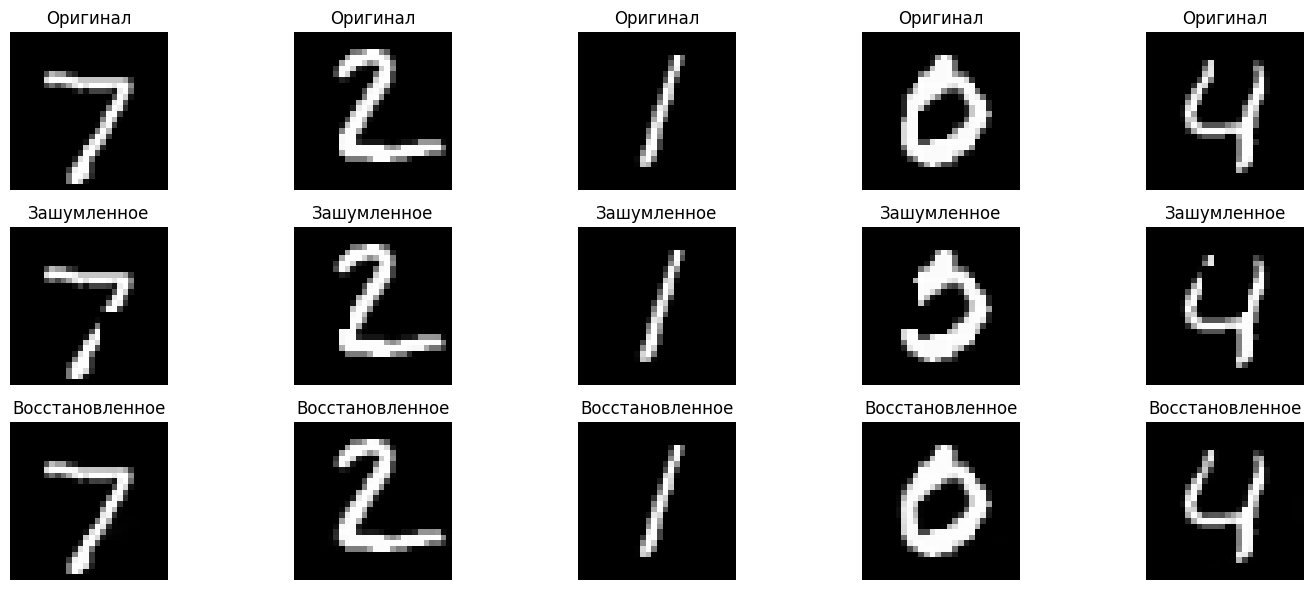

In [40]:
def plot_results(original, noisy, decoded, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # Оригинал
        plt.subplot(3, n, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Оригинал")
        plt.axis('off')

        # Зашумленное
        plt.subplot(3, n, i+1+n)
        plt.imshow(noisy[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Зашумленное")
        plt.axis('off')

        # Восстановленное
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(decoded[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title("Восстановленное")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Предсказание с проверкой данных
decoded_imgs = model.predict(noisy_X_test[:5])

# Проверка диапазона значений
print("Диапазон значений в decoded_imgs:", decoded_imgs.min(), decoded_imgs.max())
plot_results(X_test[:5], noisy_X_test[:5], decoded_imgs)